In [2]:
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from node2vec import Node2Vec
import os
import pickle

pd.set_option('display.max_columns', None)


# Load the dataset from backoffice
df_pueblos = pd.read_csv("../../data/end_product_data/pueblos_recommender.csv")

pueblos_cmun = df_pueblos['cmun'].tolist()

# Load the dataset from user chosen villages
user_files = os.listdir("../../data/user_output/")

user_choices = []

# Get all files from the user_output directory

# Read each file into a DataFrame and add to the list
for file in user_files:
    file_path = os.path.join("../../data/user_output/", file)
    user_df = pd.read_csv(file_path)
    user_choices.append(user_df)

# user choices of first user
user_choices_cmun = user_choices[0].cmun.tolist()
display(pueblos_cmun)
display(user_choices_cmun)

/Users/kaygensmann/www/python/bootcamp/ml-pueblos/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[15061,
 27025,
 27013,
 15025,
 33070,
 27063,
 15076,
 33021,
 33023,
 27038,
 15049,
 33039,
 15081,
 27005,
 33069,
 27002,
 33017,
 33018,
 15055,
 33030,
 33019,
 39047,
 39006,
 27027,
 39011,
 27033,
 33074,
 33056,
 15051,
 39005,
 39043,
 39061,
 33013,
 27061,
 33077,
 33010,
 39029,
 33007,
 27030,
 48012,
 39044,
 39009,
 33009,
 15015,
 39040,
 33054,
 48056,
 33065,
 33059,
 33063,
 39062,
 48068,
 48014,
 48077,
 48031,
 39031,
 33042,
 48076,
 39036,
 48048,
 39076,
 39080,
 39024,
 48021,
 48061,
 39068,
 48028,
 39028,
 39084,
 48089,
 39095,
 39099,
 33055,
 33045,
 39038,
 39001,
 27001,
 48064,
 48040,
 48049,
 33071,
 27054,
 33040,
 48033,
 39102,
 27021,
 48908,
 39030,
 48053,
 48041,
 39048,
 27048,
 48913,
 48063,
 15091,
 39002,
 39037,
 48010,
 39064,
 39090,
 48907,
 33043,
 48906,
 48047,
 33029,
 33006,
 39091,
 48035,
 48004,
 15050,
 15043,
 39018,
 48909,
 33046,
 48079,
 48018,
 39019,
 48903,
 48038,
 48914,
 33075,
 33047,
 39033,
 33057,
 20056,


[40214, 2024, 10064, 40179, 26061]

In [3]:
df_pueblos_enc = df_pueblos.filter(regex=r"^enc_", axis=1)
# Select only numerical features with more than 2 unique values (non-binary features)
pueblos_numerical_features = df_pueblos_enc.loc[:, (df_pueblos_enc.nunique() > 2)]

# Process user choices: filter for encoded features and remove binary columns
processed_user_choices = []
for df in user_choices:
    df_filtered = df.filter(regex=r"^enc_", axis=1)
    df_non_binary = df_filtered.loc[:, ~(df_filtered.isin([0.0, 1.0]).all())]
    processed_user_choices.append(df_non_binary)

display(processed_user_choices[0])
display(pueblos_numerical_features)


,enc_scaled__total_population,enc_scaled__female,enc_scaled__score_connectivity,enc_scaled__score_economy,enc_scaled__score_area_economy,enc_scaled__score_hospital_distance,enc_scaled__score_area_hospital,enc_scaled__score_school_distance,enc_scaled__score_area_school,enc_scaled__score_transport,enc_scaled__score_age
0,-0.558674,-0.559137,1.079668,-0.400296,-0.400296,1.817426,1.817426,-0.265322,-0.265322,-0.619807,0.391722
1,2.860713,2.837166,1.051989,2.953534,2.953534,-0.892572,-0.892572,-0.265322,-0.265322,0.465618,1.059229
2,0.491932,0.488188,1.079668,-0.400296,-0.400296,-0.505430,-0.505430,0.719746,0.719746,1.764167,-0.026148
3,0.077198,0.096428,1.118743,0.593067,0.593067,-0.892572,-0.892572,0.719746,0.719746,0.740058,1.225439
4,0.914535,0.873629,1.024311,0.524220,0.524220,-0.892572,-0.892572,0.719746,0.719746,0.133787,0.529041


,enc_scaled__total_population,enc_scaled__female,enc_scaled__score_connectivity,enc_scaled__score_economy,enc_scaled__score_area_economy,enc_scaled__score_hospital_distance,enc_scaled__score_area_hospital,enc_scaled__score_school_distance,enc_scaled__score_area_school,enc_scaled__score_transport,enc_scaled__score_age
0,3.557181,3.802348,-0.613597,4.173109,4.173109,-0.892572,-0.892572,0.719746,0.719746,5.792635,-0.473490
1,1.865195,1.788261,0.820793,0.416032,0.416032,1.043140,1.043140,0.719746,0.719746,2.815405,0.672636
2,2.560877,2.638127,0.544010,0.652079,0.652079,1.817426,1.817426,0.719746,0.719746,2.739097,0.136504
3,0.059098,0.101167,-1.261597,0.071797,0.071797,-0.118287,-0.118287,0.719746,0.719746,3.798159,-0.410759
4,2.080038,2.202136,0.778462,1.271701,1.271701,0.268855,0.268855,0.719746,0.719746,2.550249,-0.029549
...,...,...,...,...,...,...,...,...,...,...,...
6819,3.610695,3.472196,1.024311,1.950336,1.950336,-0.505430,-0.505430,0.719746,0.719746,0.327924,1.572655
6820,0.522624,0.496086,0.571688,0.337350,0.337350,0.268855,0.268855,0.719746,0.719746,-1.010917,0.596693
6821,3.386409,3.300011,0.545638,2.294571,2.294571,-0.892572,-0.892572,0.719746,0.719746,-0.159224,1.345018
6822,1.622808,1.682423,1.079668,0.337350,0.337350,1.817426,1.817426,0.719746,0.719746,-0.842902,1.366077


In [7]:
# 1️⃣ Construct the Graph
G = nx.Graph()
for i, row in pueblos_numerical_features.iterrows():
    # get cmun of row
    cmun = df_pueblos.iloc[i, 0]
    G.add_node(cmun, **row.to_dict())

# Compute pairwise feature similarity (Cosine Similarity)
feature_matrix = pueblos_numerical_features
similarity_matrix = cosine_similarity(feature_matrix)

display(len(feature_matrix))

# Add edges based on similarity threshold
threshold = 0.9  # Adjust threshold based on data distribution
# Use batching for edge creation to avoid memory issues
batch_size = 2000
for i in range(len(feature_matrix)):
    for j in range(i + 1, min(i + batch_size, len(feature_matrix))):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])

6824

In [ ]:
# from sklearn.metrics import silhouette_score
# import numpy as np

# # Test different dimensions
# dimensions_to_test = [16, 24, 32, 48, 64]
# scores = []

# for dim in dimensions_to_test:
#     # Create and train model
#     node2vec = Node2Vec(G, dimensions=dim, walk_length=10, num_walks=20, workers=12)
#     model = node2vec.fit(window=5, min_count=1)
    
#     # Extract embeddings
#     embeddings = np.array([model.wv[str(node)] for node in G.nodes()])
    
#     # Evaluate using silhouette score (requires clustering)
#     from sklearn.cluster import KMeans
#     kmeans = KMeans(n_clusters=5, random_state=42)
#     clusters = kmeans.fit_predict(embeddings)
#     score = silhouette_score(embeddings, clusters)
    
#     scores.append((dim, score))
#     print(f"Dimensions: {dim}, Silhouette Score: {score:.4f}")

# # Find best dimension
# best_dim = max(scores, key=lambda x: x[1])[0]
# print(f"Best dimension: {best_dim}")

Generating walks (CPU: 12): 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


Dimensions: 16, Silhouette Score: 0.5016


Generating walks (CPU: 12): 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


Dimensions: 24, Silhouette Score: 0.4950


Generating walks (CPU: 12): 100%|██████████| 1/1 [00:00<00:00,  9.87it/s]


Dimensions: 32, Silhouette Score: 0.4941


Generating walks (CPU: 12): 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


Dimensions: 48, Silhouette Score: 0.4936


Generating walks (CPU: 12): 100%|██████████| 1/1 [00:00<00:00,  9.80it/s]


Dimensions: 64, Silhouette Score: 0.4947
Best dimension: 16


In [6]:
# 2️⃣ Generate Node2Vec Embeddings
node2vec = Node2Vec(G, dimensions=16, walk_length=15, num_walks=100, workers=6)

Generating walks (CPU: 6): 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


In [8]:
model = node2vec.fit(
    window=5,    
    min_count=1, 
    batch_words=50,  
    epochs=5,    
    sg=0,            
    hs=0,          
    negative=7        
)

In [6]:
display(similarity_matrix)

array([[ 1.        ,  0.723396  ,  0.69736333, ...,  0.72957946,
         0.16038188, -0.06239642],
       [ 0.723396  ,  1.        ,  0.96367783, ...,  0.52713098,
         0.58274212, -0.31754954],
       [ 0.69736333,  0.96367783,  1.        , ...,  0.54329762,
         0.67090616, -0.37992173],
       ...,
       [ 0.72957946,  0.52713098,  0.54329762, ...,  1.        ,
         0.51065835, -0.36601523],
       [ 0.16038188,  0.58274212,  0.67090616, ...,  0.51065835,
         1.        , -0.72235604],
       [-0.06239642, -0.31754954, -0.37992173, ..., -0.36601523,
        -0.72235604,  1.        ]])

In [9]:
# Create models directory if it doesn't exist
os.makedirs('../../models', exist_ok=True)

# Save the Node2Vec embeddings
model_path = '../../models/node2vec.model'
model.save(model_path)

print(f"Model saved to {model_path}")

# If you want to save the graph separately
graph_path = '../../models/village_graph.pkl'
with open(graph_path, 'wb') as f:
    pickle.dump(G, f)
    
print(f"Graph saved to {graph_path}")

Model saved to ../../models/node2vec.model
Graph saved to ../../models/village_graph.pkl


## Why Do We Use node2vec If We Just Use Cosine Similarity Later?

Good question! Here’s why:

✅ node2vec learns embeddings that capture graph structure (community, structural similarities, etc.).
✅ These embeddings are better than raw features for similarity because they encode relationships beyond direct numerical similarity.
✅ Cosine similarity works on embeddings (not raw data), meaning it measures similarity in a meaningful latent space.

So, node2vec transforms the problem:

Instead of comparing raw village features, we compare graph-informed village embeddings using cosine similarity.

In [47]:
# 3️⃣ Compute Similarity
user_selected_villages = user_choices_cmun # Example selected villages
selected_vectors = [model.wv[str(v)] for v in user_selected_villages]
centroid_vector = np.mean(selected_vectors, axis=0)

# Rank all villages based on cosine similarity
all_village_vectors = {v: model.wv[str(v)] for v in G.nodes()}
similarities = {v: cosine_similarity([centroid_vector], [vec])[0][0] for v, vec in all_village_vectors.items()}
ranked_villages = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

# 4️⃣ Evaluate Ranking Quality
def ndcg_at_k(ranked_list, ideal_list, k):
    def dcg(scores):
        return sum([(2**s - 1) / np.log2(i+2) for i, s in enumerate(scores)])
    
    ideal_scores = [1 if v in ideal_list else 0 for v, _ in ranked_list[:k]]
    return dcg(ideal_scores) / dcg(sorted(ideal_scores, reverse=True))

ndcg_score = ndcg_at_k(ranked_villages, user_selected_villages, k=10)
print(f"NDCG Score: {ndcg_score:.4f}")

# Display top similar villages
print("Top 10 Most Similar Villages:")
for village, score in ranked_villages[:10]:
    print(f"Village {village}: Similarity {score:.4f}")


NDCG Score: 1.0000
Top 10 Most Similar Villages:
Village 2024: Similarity 0.9998
Village 2234: Similarity 0.9972
Village 1837: Similarity 0.9958
Village 2279: Similarity 0.9890
Village 2333: Similarity 0.9845
Village 2034: Similarity 0.9826
Village 1514: Similarity 0.9811
Village 1833: Similarity 0.9800
Village 1992: Similarity 0.9782
Village 1896: Similarity 0.9658


/var/folders/w9/bt5d4t050m7fd91t2r7l1mlh0000gn/T/ipykernel_35551/3696273799.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=village_ids, y=similarity_scores, palette="viridis")


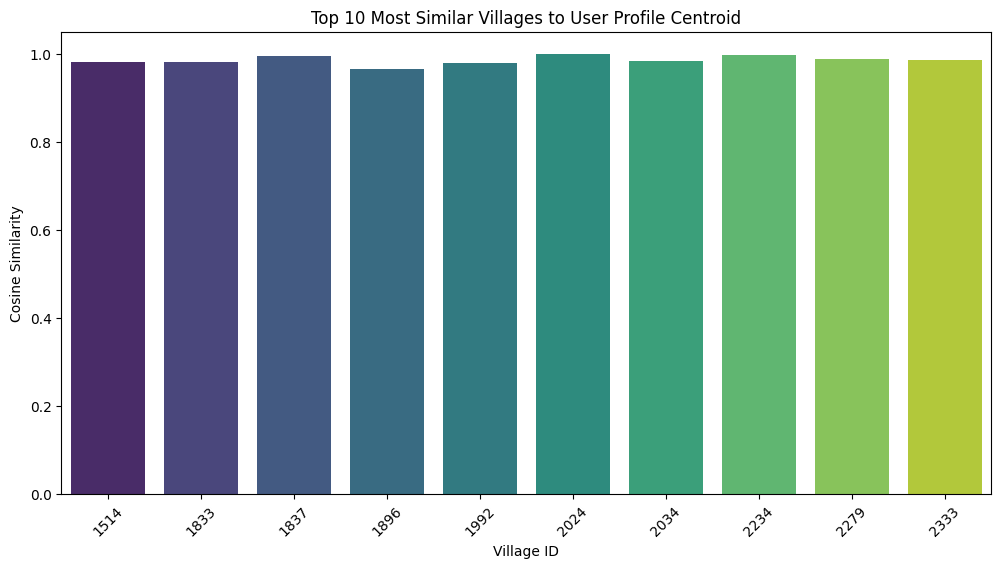

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract top 10 similar villages and their scores
top_villages = ranked_villages[:10]
village_ids = [v for v, _ in top_villages]
similarity_scores = [s for _, s in top_villages]

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=village_ids, y=similarity_scores, palette="viridis")
plt.xlabel("Village ID")
plt.ylabel("Cosine Similarity")
plt.title("Top 10 Most Similar Villages to User Profile Centroid")
plt.xticks(rotation=45)
plt.show()

### Compute the Graph Density
Graph density tells us how connected the graph is.
A fully connected graph has density 1, while a sparse graph has density close to 0.

If density > 0.1, your graph might be too dense.
If density < 0.01, it might be too sparse.

In [21]:
import networkx as nx

density = nx.density(G)
print(f"Graph Density: {density:.4f}")


Graph Density: 0.0516


In [10]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def plot_graph(G, figsize=(12, 10), node_size=50, sample=None, title="Village Network Graph"):
    """
    Plot the graph G with various visualization options.
    
    Parameters:
    - G: NetworkX graph
    - figsize: Figure size tuple (width, height)
    - node_size: Size of nodes in the plot
    - sample: If provided, visualize only a sample of nodes (int or None)
    - title: Plot title
    """
    # Create a copy to avoid modifying the original graph
    if sample is not None and sample < len(G.nodes()):
        # Sample nodes if the graph is too large
        nodes = list(G.nodes())
        sampled_nodes = np.random.choice(nodes, size=sample, replace=False)
        H = G.subgraph(sampled_nodes)
    else:
        H = G.copy()
    
    plt.figure(figsize=figsize)
    
    # Choose a layout algorithm based on graph size
    if len(H.nodes()) < 500:
        pos = nx.spring_layout(H, seed=42)  # Force-directed layout
    else:
        pos = nx.kamada_kawai_layout(H)  # Better for larger graphs
    
    # Get node degrees for sizing (optional)
    node_degrees = dict(H.degree())
    node_sizes = [node_size * (1 + 0.5 * node_degrees[n]) for n in H.nodes()]
    
    # Draw the graph
    nx.draw_networkx(
        H,
        pos=pos,
        with_labels=False,  # Set to True for small graphs
        node_size=node_sizes,
        node_color="skyblue",
        edge_color="gray",
        alpha=0.8,
        width=0.5
    )
    
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
    print(f"Graph visualization: {len(H.nodes())} nodes and {len(H.edges())} edges")
    

# Basic usage
plot_graph(G)

# For large graphs, use a sample
# plot_graph(G, sample=100, title="Sampled Village Network")

# More detailed visualization
def plot_detailed_graph(G, figsize=(14, 12), node_feature=None, highlight_nodes=None):
    """
    Create a more detailed graph visualization.
    
    Parameters:
    - G: NetworkX graph
    - figsize: Figure size tuple
    - node_feature: Dictionary with node values for coloring (optional)
    - highlight_nodes: List of nodes to highlight (optional)
    """
    plt.figure(figsize=figsize)
    
    # Sample the graph if it's very large
    if len(G.nodes()) > 1000:
        H = G.subgraph(np.random.choice(list(G.nodes()), 500, replace=False))
    else:
        H = G
    
    pos = nx.spring_layout(H, seed=42)
    
    # Node colors based on communities or other features
    if node_feature:
        node_colors = [node_feature.get(node, 0) for node in H.nodes()]
        cmap = plt.cm.viridis
        vmin = min(node_colors)
        vmax = max(node_colors)
    else:
        # Default coloring
        node_colors = 'skyblue'
        cmap = None
        vmin = vmax = None
    
    # Basic nodes
    nx.draw_networkx_nodes(
        H, pos,
        node_size=80,
        node_color=node_colors,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        alpha=0.7
    )
    
    # Highlight specific nodes if provided
    if highlight_nodes:
        highlight_nodes = [n for n in highlight_nodes if n in H.nodes()]
        if highlight_nodes:
            nx.draw_networkx_nodes(
                H, pos,
                nodelist=highlight_nodes,
                node_size=150,
                node_color='red',
                edgecolors='black',
                linewidths=2
            )
    
    # Draw edges with reduced opacity
    nx.draw_networkx_edges(
        H, pos,
        width=0.3,
        alpha=0.4,
        edge_color='gray'
    )
    
    # Add labels for a subset of nodes or important nodes
    if len(H.nodes()) < 100:
        nx.draw_networkx_labels(H, pos, font_size=8)
    
    plt.title("Village Network Visualization", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage with highlight_nodes
top_villages = [v[0] for v in ranked_villages[:5]]  # Top 5 villages from previous results
plot_detailed_graph(G, highlight_nodes=top_villages)

KeyboardInterrupt: 

<Figure size 1200x1000 with 0 Axes>